In [1]:
import sys, os
import numpy as np
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from matplotlib.colors import Normalize

local_path = 'C:/Users/rachi/OneDrive/Documents/Score-matching-project'
sys.path.append(local_path)

%load_ext autoreload
%autoreload 2

import dataset
from dataset import sampling, densities, scores, visualisation
import score_matching
from score_matching import toy_models, learning_objectives, score_visualisation
import mcmc_sampling
from mcmc_sampling import langevin, dynamics_plot, interacting_mcmc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data creation

### GMM

In [2]:
# Parameters
N = 10000
mus = [np.array([0, 0]), np.array([10,10])]
sigmas = [np.eye(2), np.eye(2)]
alphas = [0.2, 0.8]

# Dataset
gmm_data, clusters = sampling.gaussian_mixture_sampling(mus, sigmas, alphas, N)

# Annealed Langevin Dynamics

## NCSN Training

In [3]:
# Parameters

learning_rate = 1e-3
num_epochs = 1000

sigma_begin = 1 
sigma_end = 0.01
num_levels = 10 # number of sigmas to generate, in the paper it's represent as L 

## vector of num_classes of sigmas to use for data pertubation 
noise_levels = torch.tensor(np.exp(np.linspace(np.log(sigma_begin), np.log(sigma_end), num_levels))).float() 

# Our approximation model
ncsn = toy_models.ConditionalModel(num_levels)

# Learning objective
optimizer = torch.optim.Adam(ncsn.parameters(), lr=learning_rate)
ScoreMatching = learning_objectives.ScoreMatching(optimizer, 'anneal_denoising_score_matching', device, sigma = noise_levels) # sigmas here is for data's pertubation 

In [11]:
ScoreMatching.train(gmm_data, ncsn, num_epochs, verbose=False, plot=False)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 49.70it/s]

Training finished!


## Annealed Langevin Sampling

In [7]:
step = 1e-4
iterations = 300
n_samples = 10000

target_samples_annealed, hist_samples_annealed = interacting_mcmc.annealed_langevin(ncsn, step, noise_levels, 
                                                                                    iterations, n_samples, **{'data_type':'gmm'})

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:52<00:00,  5.27s/it]


In [8]:
# Samples without annealing
gmm_samples = langevin.unnadjusted_langevin_sampling(scores.gaussian_mixture_score, 1e-2, 
                                                     iterations, 1000, mus, sigmas, alphas)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:20<00:00, 12.45it/s]


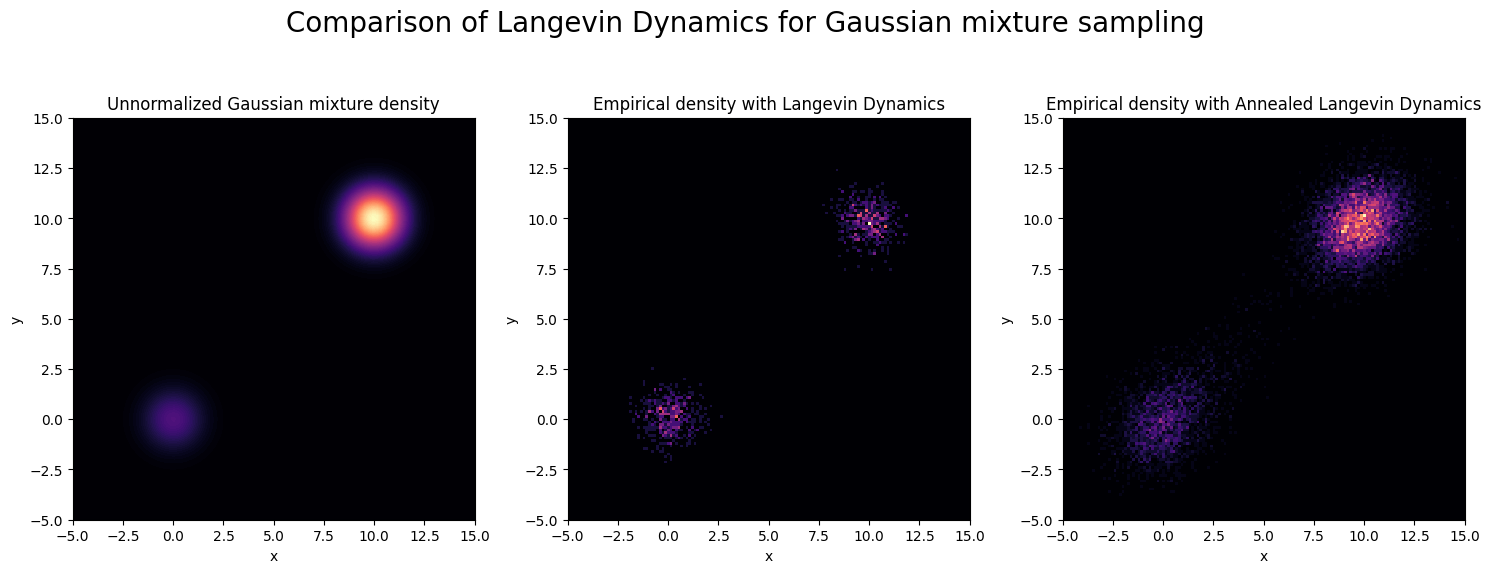

In [25]:
dynamics_plot.annealed_langevin_sampling_comparison(gmm_samples, target_samples_annealed, mus, sigmas, alphas)